In [210]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import time
from scipy import signal
import regex as reg
from pyriemann.estimation import XdawnCovariances
from pyriemann.tangentspace import TangentSpace

# Pre-Processing

things to do: ICA filtering to remove artifacts, butterworth filter, epoching ...

In [12]:
train_labels = pd.read_csv('Data/TrainLabels.csv')
submission = pd.read_csv('Data/SampleSubmission.csv')

In [231]:
submission

,IdFeedBack,Prediction
0,S01_Sess01_FB001,0
1,S01_Sess01_FB002,0
2,S01_Sess01_FB003,0
3,S01_Sess01_FB004,0
4,S01_Sess01_FB005,0
...,...,...
3395,S25_Sess05_FB096,0
3396,S25_Sess05_FB097,0
3397,S25_Sess05_FB098,0
3398,S25_Sess05_FB099,0


There are 60 feedbacks for each session, AKA, 12 5 letter words. Each feedback/letter was either a right or wrong prediction from the user. Using the EEG data, we must train a model on the tendencies within the EEG data itself, whenever a feedback was presented.

In [13]:
train_labels

,IdFeedBack,Prediction
0,S02_Sess01_FB001,1
1,S02_Sess01_FB002,1
2,S02_Sess01_FB003,0
3,S02_Sess01_FB004,0
4,S02_Sess01_FB005,1
...,...,...
5435,S26_Sess05_FB096,1
5436,S26_Sess05_FB097,0
5437,S26_Sess05_FB098,0
5438,S26_Sess05_FB099,0


Collecting all the names of the training files, and then running a loop through each file, it is imported as a DataFrame, and then turned into an array, where it is appended to the training/test set.

In [2]:
train_files = glob.glob('Data/train/Data*.csv')
test_files = glob.glob('Data/test/Data*.csv')
train_files[0:6]

['Data/train\\Data_S02_Sess01.csv',
 'Data/train\\Data_S02_Sess02.csv',
 'Data/train\\Data_S02_Sess03.csv',
 'Data/train\\Data_S02_Sess04.csv',
 'Data/train\\Data_S02_Sess05.csv',
 'Data/train\\Data_S06_Sess01.csv']

In [231]:
'''
extract_d(files)
Ingest Data by looping through files

Epoch 1.3 seconds after feedbackevent == 1 using epoch_d function

Append values to list of arrays called temp


Input: 
    files: array of string of file names (Data_S*_Sess*.csv)
Output: 
    temp: final array of appended values
'''
def extract_d(files):
    start = time.time()
    
    freq = 200
    epoch_time = 1.3
    epoch = freq * epoch_time
    temp = np.empty((1,260,59), float)
    for i, f in enumerate(files):
        print(i,f, temp.shape)
        df = pd.read_csv(f)
        #using regex to extract subject and session numbers
        [(subject, session)] = reg.findall('Data/.+S(\d\d).+s(\d\d)',f)
        #df.loc[:,'Subject'] = subject
        #df.loc[:,'Session'] = session
        index_fb = df[df['FeedBackEvent'] == 1].index.values
        df = np.array(df)
        for j, indx in enumerate(index_fb):
            epoch_array = df[indx:(indx+int(epoch)),:]
            #feedback_col = np.ones((epoch_array.shape[0],1)) + j
            #epoch_array = np.append(epoch_array, feedback_col, 1)
            #print(indx, epoch_array.shape)
            epoch_array = epoch_array.reshape((1,int(epoch),int(epoch_array.shape[1])))
            if i == 0:
                temp = np.vstack((temp,epoch_array))
                #temp[0] = epoch_array
            else:
                temp = np.vstack((temp,epoch_array))
                
    now = time.time()
    print('Elapsed Time: ' + str(int(now-start)) + ' seconds')
    return temp

In [164]:
train = extract_d2(train_files)

0 Data/train\Data_S02_Sess01.csv (1, 260, 59)
1 Data/train\Data_S02_Sess02.csv (61, 260, 59)
2 Data/train\Data_S02_Sess03.csv (121, 260, 59)
3 Data/train\Data_S02_Sess04.csv (181, 260, 59)
4 Data/train\Data_S02_Sess05.csv (241, 260, 59)
5 Data/train\Data_S06_Sess01.csv (341, 260, 59)
6 Data/train\Data_S06_Sess02.csv (401, 260, 59)
7 Data/train\Data_S06_Sess03.csv (461, 260, 59)
8 Data/train\Data_S06_Sess04.csv (521, 260, 59)
9 Data/train\Data_S06_Sess05.csv (581, 260, 59)
10 Data/train\Data_S07_Sess01.csv (681, 260, 59)
11 Data/train\Data_S07_Sess02.csv (741, 260, 59)
12 Data/train\Data_S07_Sess03.csv (801, 260, 59)
13 Data/train\Data_S07_Sess04.csv (861, 260, 59)
14 Data/train\Data_S07_Sess05.csv (921, 260, 59)
15 Data/train\Data_S11_Sess01.csv (1021, 260, 59)
16 Data/train\Data_S11_Sess02.csv (1081, 260, 59)
17 Data/train\Data_S11_Sess03.csv (1141, 260, 59)
18 Data/train\Data_S11_Sess04.csv (1201, 260, 59)
19 Data/train\Data_S11_Sess05.csv (1261, 260, 59)
20 Data/train\Data_S12_Sess0

In [189]:
Y_train = train_labels.Prediction.values

In [232]:
XC= XdawnCovariances(nfilter=5)
X_train = XC.fit_transform(train[1:], Y_train)

In [171]:
test = extract_d2(test_files)

0 Data/test\Data_S01_Sess01.csv (1, 260, 59)
1 Data/test\Data_S01_Sess02.csv (61, 260, 59)
2 Data/test\Data_S01_Sess03.csv (121, 260, 59)
3 Data/test\Data_S01_Sess04.csv (181, 260, 59)
4 Data/test\Data_S01_Sess05.csv (241, 260, 59)
5 Data/test\Data_S03_Sess01.csv (341, 260, 59)
6 Data/test\Data_S03_Sess02.csv (401, 260, 59)
7 Data/test\Data_S03_Sess03.csv (461, 260, 59)
8 Data/test\Data_S03_Sess04.csv (521, 260, 59)
9 Data/test\Data_S03_Sess05.csv (581, 260, 59)
10 Data/test\Data_S04_Sess01.csv (681, 260, 59)
11 Data/test\Data_S04_Sess02.csv (741, 260, 59)
12 Data/test\Data_S04_Sess03.csv (801, 260, 59)
13 Data/test\Data_S04_Sess04.csv (861, 260, 59)
14 Data/test\Data_S04_Sess05.csv (921, 260, 59)
15 Data/test\Data_S05_Sess01.csv (1021, 260, 59)
16 Data/test\Data_S05_Sess02.csv (1081, 260, 59)
17 Data/test\Data_S05_Sess03.csv (1141, 260, 59)
18 Data/test\Data_S05_Sess04.csv (1201, 260, 59)
19 Data/test\Data_S05_Sess05.csv (1261, 260, 59)
20 Data/test\Data_S08_Sess01.csv (1361, 260, 59)

In [ ]:
X_test = XC.transform(test[1:])

In [234]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (5440, 20, 20)
X_test shape:  (3400, 20, 20)


In [ ]:
np.save('Data/X_train.npy',X_train)
np.save('Data/X_test.npy',X_test)

## IGNORE BELOW OLD FORMAT IMPLEMENTATION OF ARRAY AND DATAFRAME

Output new arrays into 2 csvs for model use

In [130]:
cols = ['Time', 'Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
       'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
       'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
       'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
       'POz', 'P08', 'O1', 'O2', 'EOG', 'FeedBackEvent']
test_df = pd.DataFrame(test, columns = cols)
#test_df.to_csv('Data/test_df.csv')

In [129]:
cols = ['Time', 'Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
       'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
       'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
       'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
       'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
       'POz', 'P08', 'O1', 'O2', 'EOG', 'FeedBackEvent']
train_df = pd.DataFrame(train, columns = cols)
#train_df.to_csv('Data/train_df.csv')

Butter worth filter:

In [7]:
train_df = pd.read_csv('Data/train_df.csv')
test_df = pd.read_csv('Data/test_df.csv')

In [131]:
def butter_filter(order, low_pass, high_pass, fs,sig):
    nyq = 0.5 * fs
    lp = low_pass / nyq
    hp = high_pass / nyq
    sos = signal.butter(order, [lp, hp], btype='band', output = 'sos')
    return signal.sosfilt(sos, sig)

In [135]:
train_df

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,47.995,830.677222,979.638619,847.257758,766.929505,555.929311,853.074414,777.926970,910.416082,798.451960,...,568.057948,817.546838,741.133120,742.770663,313.393700,932.304475,750.347476,969.756009,-1591.606547,1.0
1,48.000,882.209104,1030.107902,913.807570,812.766611,628.762774,943.759560,829.574747,950.801367,862.540552,...,621.804126,893.748267,797.760199,797.781207,429.621296,1000.885015,828.234082,1158.873289,-1588.647308,0.0
2,48.005,838.759996,984.945818,848.060414,776.813692,560.079200,877.227293,789.030120,931.764316,810.307598,...,584.872322,829.933143,760.032927,760.722913,405.090442,946.093298,754.041038,1171.585312,-1562.819303,0.0
3,48.010,850.299406,1002.149913,879.647377,789.381850,586.861880,906.211081,805.209759,946.101601,835.004476,...,592.235988,851.442824,768.844177,762.088213,355.818714,968.994563,783.657854,1047.508574,-1560.461633,0.0
4,48.015,831.695716,974.484768,850.070984,765.199808,546.564539,855.763429,762.342678,894.460988,784.311915,...,569.011562,811.967014,745.640771,748.335131,308.473211,930.161509,743.507712,974.614142,-1592.115556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246955,650.200,-391.807685,-185.234923,-413.282104,-288.705416,-211.514345,-312.125935,-356.216693,-312.519897,-257.865947,...,-321.870381,-314.500413,-328.421099,-298.939678,-337.539499,-325.494648,-281.634972,-344.862761,-143.576142,0.0
1246956,650.205,-334.173522,-162.458524,-355.355901,-302.019396,-225.536970,-301.389093,-331.273360,-299.509225,-277.677737,...,-321.929148,-322.311023,-327.159393,-296.356885,-341.383110,-341.416381,-295.717568,-352.160173,-151.451023,0.0
1246957,650.210,-293.547046,-110.355694,-298.201788,-247.364895,-168.226125,-211.820572,-300.421955,-266.267676,-228.290588,...,-294.346254,-269.563591,-301.520990,-263.893004,-288.034991,-278.263557,-221.182315,-294.567677,-142.001595,0.0
1246958,650.215,-317.018590,-178.284104,-366.257481,-292.307386,-249.069717,-306.362927,-348.740448,-290.929817,-311.700591,...,-325.196585,-334.258946,-328.666044,-299.253840,-349.846429,-358.416497,-320.755517,-359.842919,-151.373051,0.0


In [138]:
sig = np.array(train)
EEG = sig[:,1:-2]

In [139]:
order = 5
low_pass = 1
high_pass = 40
fs = 200
filtered = butter_filter(order, low_pass, high_pass, fs, EEG)

In [143]:
df_filt = pd.DataFrame(filtered, columns = cols[1:-2])
df_filt.insert(0, column='Time', value=train_df.Time)
df_filt['FeedBackEvent'] = train_df.FeedBackEvent
df_filt

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P2,P4,P6,P8,PO7,POz,P08,O1,O2,FeedBackEvent
0,47.995,16.487111,117.488482,372.896142,694.320804,835.750085,672.111795,378.058242,228.048886,287.564569,...,-202.710706,-264.157470,-339.862939,-310.514648,-156.122245,-12.295022,-18.975215,-138.891111,-184.346622,1.0
1,48.000,17.509906,124.572493,395.090651,736.027768,888.536174,721.813807,420.115324,267.333835,323.076571,...,-220.742269,-279.470338,-358.551274,-333.865650,-179.177585,-30.056612,-29.341489,-140.290493,-176.861588,0.0
2,48.005,16.647537,118.547828,375.878174,699.023533,840.485896,676.157025,383.422964,237.379723,300.467263,...,-218.129361,-268.393112,-336.814038,-312.927363,-170.899844,-31.079496,-25.481098,-126.223840,-163.499423,0.0
3,48.010,16.876568,120.251287,381.875977,712.086500,859.715545,696.295571,399.921447,250.050479,310.331021,...,-210.373194,-270.622481,-344.522688,-313.203896,-156.367262,-10.708812,-17.106925,-136.062975,-177.556270,0.0
4,48.015,16.507326,117.506402,372.638490,693.488994,834.513015,670.566801,375.590366,223.788286,280.528118,...,-204.382716,-267.366012,-340.989104,-309.370981,-154.954088,-11.686671,-17.832270,-137.933515,-185.979399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246955,650.200,-7.776519,-49.921558,-143.481207,-247.519993,-290.038855,-246.159930,-162.251826,-111.745142,-121.698611,...,49.477536,87.497296,108.730976,94.627146,66.127212,52.825453,58.791912,66.314264,64.874107,0.0
1246956,650.205,-6.632608,-42.666937,-122.960043,-213.850086,-257.275062,-233.898626,-175.941461,-133.464470,-128.909401,...,58.220593,95.325821,116.174737,102.055326,72.503659,58.034922,64.037457,70.615325,64.576007,0.0
1246957,650.210,-5.826262,-36.837669,-103.915961,-176.483978,-207.738451,-185.259269,-134.972909,-98.799420,-102.348693,...,61.244880,89.551002,99.850275,85.148095,65.443541,59.561219,66.255061,73.516336,76.685580,0.0
1246958,650.215,-6.292120,-40.956244,-120.078530,-213.421915,-262.481649,-242.571371,-184.264071,-140.962567,-136.072838,...,63.151199,102.171926,122.300348,105.929777,73.997624,58.643989,65.235024,70.744267,59.527028,0.0


In [182]:
df_filt.head(60000)

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P2,P4,P6,P8,PO7,POz,P08,O1,O2,FeedBackEvent
0,47.995,16.487111,117.488482,372.896142,694.320804,835.750085,672.111795,378.058242,228.048886,287.564569,...,-202.710706,-264.157470,-339.862939,-310.514648,-156.122245,-12.295022,-18.975215,-138.891111,-184.346622,1.0
1,48.000,17.509906,124.572493,395.090651,736.027768,888.536174,721.813807,420.115324,267.333835,323.076571,...,-220.742269,-279.470338,-358.551274,-333.865650,-179.177585,-30.056612,-29.341489,-140.290493,-176.861588,0.0
2,48.005,16.647537,118.547828,375.878174,699.023533,840.485896,676.157025,383.422964,237.379723,300.467263,...,-218.129361,-268.393112,-336.814038,-312.927363,-170.899844,-31.079496,-25.481098,-126.223840,-163.499423,0.0
3,48.010,16.876568,120.251287,381.875977,712.086500,859.715545,696.295571,399.921447,250.050479,310.331021,...,-210.373194,-270.622481,-344.522688,-313.203896,-156.367262,-10.708812,-17.106925,-136.062975,-177.556270,0.0
4,48.015,16.507326,117.506402,372.638490,693.488994,834.513015,670.566801,375.590366,223.788286,280.528118,...,-204.382716,-267.366012,-340.989104,-309.370981,-154.954088,-11.686671,-17.832270,-137.933515,-185.979399,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,581.015,13.765105,93.321949,283.064313,509.771250,611.400294,523.853883,351.191635,234.215843,220.972170,...,-166.934127,-122.662188,-154.225992,-222.294563,-256.680551,-242.352154,-208.547756,-184.677415,-192.498625,0.0
59996,581.020,14.366172,97.484844,296.212919,534.989388,644.430755,555.895602,376.979113,254.468008,237.598914,...,-170.311218,-126.435538,-162.366267,-233.550445,-266.530538,-248.436231,-211.366668,-184.070070,-187.526274,0.0
59997,581.025,13.298728,90.309415,274.389518,495.160580,595.938078,514.254699,349.006427,234.356040,218.564874,...,-156.954787,-105.131167,-138.658400,-218.021393,-264.422881,-251.762793,-204.396053,-159.859241,-155.938522,0.0
59998,581.030,13.512177,91.952290,279.995447,506.498582,611.317025,529.220991,359.851381,240.629803,222.586630,...,-162.576535,-111.670786,-142.382951,-217.171456,-260.229587,-248.315376,-206.740640,-169.871316,-169.775115,0.0


In [186]:
grouped = df_filt.groupby('Time').mean()
grouped.head()

,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,F1,...,P2,P4,P6,P8,PO7,POz,P08,O1,O2,FeedBackEvent
Time,,,,,,,,,,,,,,,,,,,,,
47.995,-2.212791,-15.848021,-49.907142,-92.775609,-119.752575,-126.059031,-120.731498,-101.812890,-74.536098,-64.018067,...,-33.623532,-12.847904,12.154968,24.733725,38.281844,63.360049,82.828744,77.495966,59.292130,0.0125
48.000,-2.100006,-15.090688,-47.600132,-88.538056,-114.518776,-121.418583,-117.339758,-98.979258,-71.639695,-61.515961,...,-35.138558,-13.523545,11.700770,24.097372,37.709454,63.173187,83.209550,78.811533,61.553967,0.0000
48.005,-2.108471,-15.184151,-48.072124,-89.896757,-116.963239,-124.396734,-120.205163,-101.760973,-74.391700,-63.570022,...,-34.563141,-12.374231,13.450600,25.492211,37.979344,62.774719,83.558122,80.567897,63.704278,0.0000
48.010,-2.139649,-15.356595,-48.420571,-90.068863,-116.387603,-122.988935,-118.613283,-100.691855,-73.908278,-63.238234,...,-33.787906,-12.892104,12.160182,24.613204,38.063288,63.211374,83.149786,78.860674,61.883721,0.0000
48.015,-2.227226,-15.954019,-50.250996,-93.415732,-120.505975,-126.716777,-121.430320,-102.836427,-75.721855,-64.846463,...,-32.495705,-11.637700,13.250531,25.490122,38.508888,63.190879,82.736874,77.800086,59.748787,0.0000


In [219]:
grouped_fb

,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,F1,...,P2,P4,P6,P8,PO7,POz,P08,O1,O2,FeedBackEvent
Time,,,,,,,,,,,,,,,,,,,,,
47.995,-2.212791,-15.848021,-49.907142,-92.775609,-119.752575,-126.059031,-120.731498,-101.812890,-74.536098,-64.018067,...,-33.623532,-12.847904,12.154968,24.733725,38.281844,63.360049,82.828744,77.495966,59.292130,0.012500
48.065,-2.233919,-16.076706,-50.864392,-94.918540,-122.665764,-128.767505,-123.048403,-104.247620,-76.741669,-64.862515,...,-33.238497,-11.567007,14.218104,26.546720,39.344522,64.248381,84.819944,81.376405,64.085799,0.012500
48.805,-2.131993,-15.356234,-48.589736,-90.617409,-117.040592,-123.027795,-117.925460,-99.852069,-72.790526,-61.000412,...,-35.901584,-14.529149,11.204102,23.664538,36.636491,61.841953,82.798769,79.415757,61.769083,0.012500
48.810,-2.161324,-15.544175,-49.059167,-91.108338,-116.915665,-121.977170,-116.412552,-98.689515,-72.398505,-61.042569,...,-34.915931,-15.012663,9.632903,22.372666,36.421321,62.123884,82.379518,78.031805,60.759335,0.012500
49.040,-2.104610,-15.111945,-47.629589,-88.429053,-113.781318,-119.421356,-114.262827,-96.061985,-69.575157,-59.380047,...,-37.294261,-16.392110,8.780369,21.554798,35.440317,60.926007,80.979352,76.583886,59.155075,0.012500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649.675,1.119504,8.437889,27.780538,53.644482,71.398672,76.553488,72.993169,59.132581,39.829300,32.746324,...,21.800087,6.946839,-7.669827,-13.034662,-19.378388,-33.315387,-44.866658,-42.971142,-34.022340,0.012987
649.685,0.997268,7.710993,25.981406,51.334618,69.975300,76.560979,73.543045,59.296747,39.730090,32.913473,...,21.671792,8.961787,-4.960739,-10.956210,-17.966026,-32.151300,-44.130009,-43.047708,-34.906173,0.012987
649.725,1.013026,7.820855,26.311237,51.859338,70.367354,76.538080,73.389544,59.510259,40.117059,32.812266,...,22.708172,9.565236,-5.067017,-11.407140,-18.352751,-32.401970,-44.241122,-42.768687,-33.951100,0.012987


In [213]:
grouped_fb = grouped[grouped.FeedBackEvent > 0]
X_fb = grouped_fb.index.values

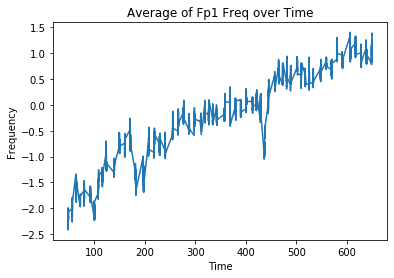

In [221]:
X = grouped.index.values
X_fb = grouped_fb.index.values
Y = grouped.Fp1
Y_fb = grouped_fb.Fp1
plt.plot(X,Y)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Average of Fp1 Freq over Time')
plt.show()

In [193]:
plt.xticks?

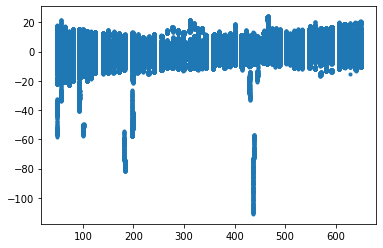

In [163]:
X = df_filt.Time
Y = df_filt.Fp1

plt.plot(X,Y)
plt.show()

In [159]:
df_filt.Time.value_counts()

457.290    80
181.745    80
181.995    80
182.005    80
617.025    80
           ..
649.970    77
649.595    77
649.720    77
649.345    77
649.650    77
Name: Time, Length: 15600, dtype: int64

In [155]:
vis_df = df_filt.drop('Time', axis=1)
vis_df[vis_df['FeedBackEvent'] == 1].mean()

Fp1              -0.717925
Fp2              -5.059033
AF7             -15.801091
AF3             -28.994729
AF4             -35.323358
AF8             -31.522774
F7              -23.562862
F5              -17.485539
F3              -14.304443
F1              -13.143482
Fz              -13.270124
F2              -13.099914
F4              -10.902905
F6               -6.897149
F8               -2.298778
FT7               3.336264
FC5              10.276298
FC3              14.559901
FC1              11.571836
FCz               4.357999
FC2               2.108894
FC4               8.253400
FC6              15.006053
FT8              14.026010
T7                9.175445
C5               11.574488
C3               22.061998
C1               27.098918
Cz               17.166398
C2                1.878732
C4               -1.977754
C6                7.711910
T8               18.687338
TP7              22.855951
CP5              22.677359
CP3              20.146877
CP1              11.957422
C

In [156]:
vis_df2 = df_filt.drop('Time', axis=1)
vis_df2[vis_df2['FeedBackEvent'] == 0].mean()

Fp1              -0.247398
Fp2              -1.814436
AF7              -5.785493
AF3             -10.700132
AF4             -13.402248
AF8             -13.538265
F7              -12.900623
F5              -11.052447
F3               -7.196610
F1               -4.128553
Fz               -5.059864
F2               -8.443863
F4               -9.831243
F6               -7.519221
F8               -2.910276
FT7               3.319392
FC5              10.517100
FC3              14.299027
FC1              10.174906
FCz               1.592867
FC2              -2.146765
FC4               2.271097
FC6               7.563400
FT8               6.594879
T7                3.687789
C5                8.436073
C3               19.274685
C1               21.911345
Cz                8.552235
C2               -8.742252
C4              -12.264820
C6               -1.186471
T8               10.253869
TP7              13.667917
CP5              13.214931
CP3              12.191798
CP1               6.220289
C

In [304]:
train_df

,Time,Fp1,Fp2,AF7,AF3,AF4,AF8,F7,F5,F3,...,P4,P6,P8,PO7,POz,P08,O1,O2,EOG,FeedBackEvent
0,47.995,830.677222,979.638619,847.257758,766.929505,555.929311,853.074414,777.926970,910.416082,798.451960,...,568.057948,817.546838,741.133120,742.770663,313.393700,932.304475,750.347476,969.756009,-1591.606547,1.0
1,48.000,882.209104,1030.107902,913.807570,812.766611,628.762774,943.759560,829.574747,950.801367,862.540552,...,621.804126,893.748267,797.760199,797.781207,429.621296,1000.885015,828.234082,1158.873289,-1588.647308,0.0
2,48.005,838.759996,984.945818,848.060414,776.813692,560.079200,877.227293,789.030120,931.764316,810.307598,...,584.872322,829.933143,760.032927,760.722913,405.090442,946.093298,754.041038,1171.585312,-1562.819303,0.0
3,48.010,850.299406,1002.149913,879.647377,789.381850,586.861880,906.211081,805.209759,946.101601,835.004476,...,592.235988,851.442824,768.844177,762.088213,355.818714,968.994563,783.657854,1047.508574,-1560.461633,0.0
4,48.015,831.695716,974.484768,850.070984,765.199808,546.564539,855.763429,762.342678,894.460988,784.311915,...,569.011562,811.967014,745.640771,748.335131,308.473211,930.161509,743.507712,974.614142,-1592.115556,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1246955,650.200,-391.807685,-185.234923,-413.282104,-288.705416,-211.514345,-312.125935,-356.216693,-312.519897,-257.865947,...,-321.870381,-314.500413,-328.421099,-298.939678,-337.539499,-325.494648,-281.634972,-344.862761,-143.576142,0.0
1246956,650.205,-334.173522,-162.458524,-355.355901,-302.019396,-225.536970,-301.389093,-331.273360,-299.509225,-277.677737,...,-321.929148,-322.311023,-327.159393,-296.356885,-341.383110,-341.416381,-295.717568,-352.160173,-151.451023,0.0
1246957,650.210,-293.547046,-110.355694,-298.201788,-247.364895,-168.226125,-211.820572,-300.421955,-266.267676,-228.290588,...,-294.346254,-269.563591,-301.520990,-263.893004,-288.034991,-278.263557,-221.182315,-294.567677,-142.001595,0.0
1246958,650.215,-317.018590,-178.284104,-366.257481,-292.307386,-249.069717,-306.362927,-348.740448,-290.929817,-311.700591,...,-325.196585,-334.258946,-328.666044,-299.253840,-349.846429,-358.416497,-320.755517,-359.842919,-151.373051,0.0
